**Прогнозирование рентабельности стартапов: анализ и моделирование**

**Заголовок:**
"Прогнозирование рентабельности стартапов: анализ и моделирование"

**Краткое описание:**
Данный проект направлен на создание моделей, способных прогнозировать рентабельность стартапов. Мы анализируем данные о стартапах, функционировавших с 1980 по 2018 годы, чтобы определить, какие из них закроются, а какие продолжат успешную деятельность. 

**План действий:**
1. **Загрузка и ознакомление с данными:**
   - Получение данных о стартапах.
   - Изучение структуры данных, оценка качества и целей проекта.

2. **Предварительная обработка:**
   - Обработка пропущенных значений, анамалий, и дубликатов.

3. **Разведочный анализ:**
   - Визуализация распределений признаков.
   - Исследование корреляций между признаками.

4. **Разработка новых синтетических признаков:**
   - Создание новых признаков на основе имеющихся данных.

5. **Проверка на мультиколлинеарность:**
   - Оценка мультиколлинеарности между признаками.

6. **Отбор финального набора обучающих признаков:**
   - Выбор наиболее значимых признаков для модели.

7. **Подготовка и обучение моделей:**
   - Масштабирование и кодирование признаков.
   - Обучение моделей на обучающих данных.

8. **Итоговая оценка качества предсказания лучшей модели:**
   - Оценка точности и других метрик моделей.

9. **Анализ важности признаков:**
   - Определение влияния каждого признака на предсказание.

10. **Подготовка отчета по исследованию:**
    - Составление отчета с результатами и выводами.

Этот проект позволит нам лучше понять факторы, влияющие на успех стартапов. 🚀

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Загрузка и ознакомление с данными

                     name                          category_list  \
0               Lunchgate        Online Reservations|Restaurants   
1                 EarLens  Manufacturing|Medical|Medical Devices   
2  Reviva Pharmaceuticals                          Biotechnology   
3    Sancilio and Company                            Health Care   
4     WireTough Cylinders                          Manufacturing   

   funding_total_usd     status country_code state_code       region  \
0           828626.0  operating          CHE         25       Zurich   
1         42935019.0  operating          USA         CA  SF Bay Area   
2         35456381.0  operating          USA         CA  SF Bay Area   
3         22250000.0  operating          NaN        NaN          NaN   
4                NaN  operating          USA         VA   VA - Other   

           city  funding_rounds  founded_at first_funding_at last_funding_at  \
0        Zürich               2  2010-06-24       2011-05-01      2014-12-01  

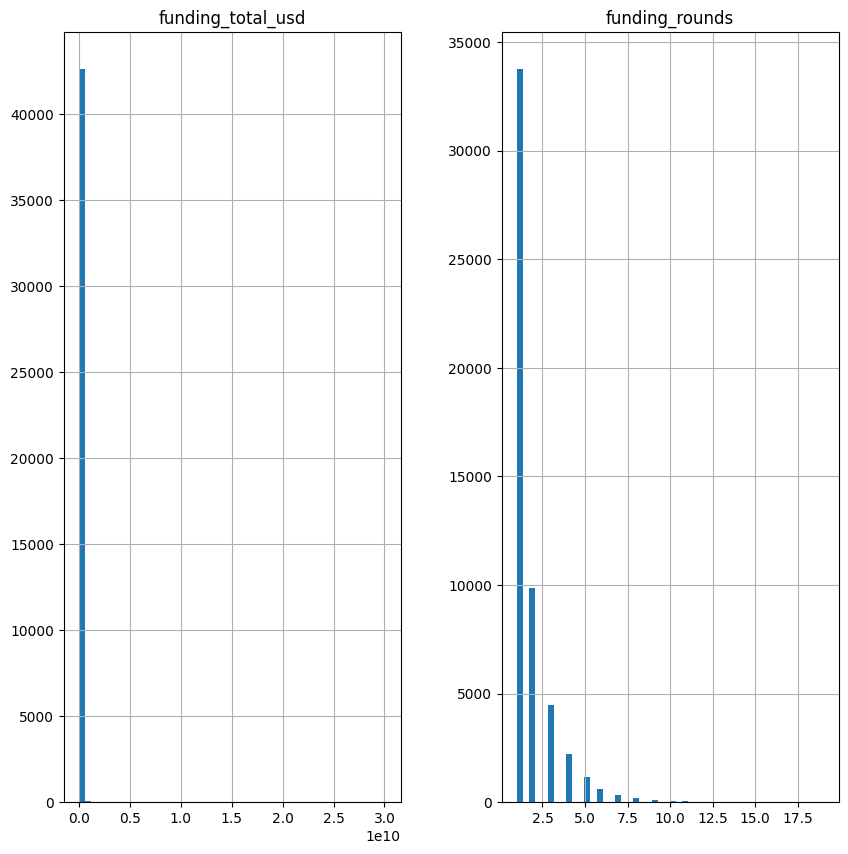

In [145]:
# Загрузка данных
df = pd.read_csv('kaggle_startups_train_01.csv')

# Просмотр первых 5 строк данных
print(df.head())

# Использование метода info
print(df.info())

# Основная статистика
print(df.describe())

# График распределения для каждого числового признака
df.hist(figsize=(10, 10), bins=50)
plt.show()

1. **Обзор данных**:
    - В таблице представлены стартапы с различными характеристиками.
    - Каждая строка соответствует отдельному стартапу.
    - Всего в данных **52879 записей**.

2. **Основные признаки**:
    - **name**: Название стартапа.
    - **category_list**: Категории, к которым относится стартап.
    - **funding_total_usd**: Общий объем финансирования в долларах США.
    - **status**: Статус стартапа (например, "operating", "closed").
    - **country_code**: Код страны.
    - **state_code**: Код штата (если применимо).
    - **region**: Регион, где находится стартап.
    - **city**: Город, где находится стартап.
    - **funding_rounds**: Количество раундов финансирования.
    - **founded_at**: Дата основания стартапа.
    - **first_funding_at**: Дата первого финансирования.
    - **last_funding_at**: Дата последнего финансирования.
    - **closed_at**: Дата закрытия (если применимо).

3. **Пропущенные значения**:
    - Некоторые признаки имеют пропущенные значения (например, **category_list**, **country_code**, **state_code**, **region**, **city**, **funding_total_usd**, **closed_at**).
    - Необходимо рассмотреть, как обрабатывать эти пропущенные значения.

4. **Статистика**:
    - Средний объем финансирования составляет **$18,930,590**.
    - Среднее количество раундов финансирования - **1.74**.

5. **График распределения**:
    - График показывает распределение числовых признаков.
    - Можно увидеть, какие значения преобладают и как они распределены.

**Вывод**: Данные содержат информацию о стартапах, и для дальнейшего анализа необходимо обратить внимание на пропущенные значения и провести более детальное исследование каждого признака. 🚀

# Предварительная обработка

In [146]:
# Преобразование дат в datetime формат
date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
df[date_columns] = df[date_columns].apply(pd.to_datetime)

In [147]:
# Проверка на дубликаты
duplicates = df.duplicated()
print(f'Количество дубликатов: {duplicates.sum()}')
if duplicates.sum() > 0:
    print('Дубликаты:')
    display(df[duplicates])

Количество дубликатов: 0


In [148]:
for col in df.columns:
    missing = df[col].isnull().sum()
    print(f'Количество пропусков в столбце {col}: {missing}')
    if missing > 0:
        print('Пропуски:')
        display(df[df[col].isnull()])


Количество пропусков в столбце name: 1
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3321,NaN,Startups,25000.0,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-12-12


Количество пропусков в столбце category_list: 2505
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
12,Iberic Premium,NaN,107239.0,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-03-19
26,The Center from Health Promotion,NaN,10000000.0,operating,NaN,NaN,NaN,NaN,1,2003-03-03,2003-11-12,2003-11-12,NaT
48,Daniel's Jewelers,NaN,NaN,operating,USA,CA,Los Angeles,Culver City,1,1948-01-01,2014-11-24,2014-11-24,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52767,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-11,2015-05-18,2015-05-18,2017-03-22
52782,"iSend, LLC",NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-01-01,2008-05-28,2008-05-28,2010-01-20
52830,Thermal Nomad,NaN,NaN,operating,USA,TX,Houston,Houston,1,2014-04-20,2014-05-28,2014-05-28,NaT
52836,Vision Software PTY,NaN,15000000.0,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaT


Количество пропусков в столбце funding_total_usd: 10126
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaT
10,Indie Vinos,Software,NaN,operating,USA,OR,"Portland, Oregon",Portland,1,2009-01-01,2013-04-21,2013-04-21,NaT
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
24,Savasti,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-03-19
25,Brightree,Software,NaN,operating,USA,GA,Atlanta,Lawrenceville,1,2007-09-13,2008-07-15,2008-07-15,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52862,StockRadar,Finance|FinTech,NaN,operating,CHN,22,Beijing,Beijing,3,2011-01-01,2011-12-01,2015-09-22,NaT
52865,Zura!,E-Commerce,NaN,operating,BRA,27,BRA - Other,Brasil,1,2006-06-03,2008-01-01,2008-01-01,NaT
52870,Proactive Comfort,Medical,NaN,operating,USA,MD,Baltimore,Centreville,1,2009-10-16,2011-01-20,2011-01-20,NaT
52871,ScramCard,NaN,NaN,operating,HKG,NaN,Hong Kong,Hong Kong,1,2013-01-01,2015-11-20,2015-11-20,NaT


Количество пропусков в столбце status: 0
Количество пропусков в столбце country_code: 5528
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaT
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaT
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52807,Plix,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-04-24
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaT


Количество пропусков в столбце state_code: 6797
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaT
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaT
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaT
52863,meetnlearn,Education,3.283930e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-07-09,2015-06-01,NaT


Количество пропусков в столбце region: 6390
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaT
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaT
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52807,Plix,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-04-24
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaT


Количество пропусков в столбце city: 6390
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3,Sancilio and Company,Health Care,2.225000e+07,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
12,Iberic Premium,NaN,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2013-10-07,2014-06-01,2014-06-01,2015-12-23
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-01-01,2014-08-28,2015-08-05,NaT
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2013-11-01,2015-02-01,2015-02-01,NaT
16,Salesjob,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52807,Plix,Advertising|Digital Media|Games|Social Media|T...,4.000000e+05,closed,NaN,NaN,NaN,NaN,1,2011-01-01,2012-01-01,2012-01-01,2013-04-24
52812,ELabsEurope,Internet|Life Sciences|Medical,2.000000e+07,closed,NaN,NaN,NaN,NaN,1,1999-07-14,2000-10-23,2000-10-23,2002-08-22
52818,Capcom groupe,Construction|Optical Communications|Telecommun...,1.065315e+07,closed,NaN,NaN,NaN,NaN,1,2013-12-25,2015-09-29,2015-09-29,2016-12-30
52836,Vision Software PTY,NaN,1.500000e+07,operating,NaN,NaN,NaN,NaN,1,1998-07-27,1999-11-02,1999-11-02,NaT


Количество пропусков в столбце funding_rounds: 0
Количество пропусков в столбце founded_at: 0
Количество пропусков в столбце first_funding_at: 21
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
1738,Product Ninja,Consumer Electronics|Design|E-Commerce|Hardwar...,NaN,operating,NaN,NaN,NaN,NaN,2,2014-01-01,NaT,2014-10-01,NaT
2353,Align Commerce,Bitcoin|Payments,1.250000e+07,operating,USA,CA,SF Bay Area,San Francisco,3,2014-02-01,NaT,2015-11-17,NaT
4325,Neumitra,Big Data Analytics|Hardware + Software|Health ...,2.000000e+04,operating,USA,MA,Boston,Boston,3,2010-01-01,NaT,2012-06-01,NaT
4327,RealMassive,Commercial Real Estate|Marketing Automation|Ma...,8.000000e+06,operating,USA,TX,Austin,Austin,2,2013-02-11,NaT,2015-05-14,NaT
4661,Sontra,Customer Service|Logistics|Transportation,4.349586e+06,operating,BRA,2,Sao Paulo,São Paulo,5,2013-01-01,NaT,2015-01-23,NaT
5811,"Golfler Holdings, LLC",Analytics|Application Platforms|Business Analy...,2.725000e+05,operating,USA,MI,Detroit,Detroit,4,2015-02-01,NaT,2015-06-14,NaT
6253,dopay,Financial Services,1.675551e+06,operating,GBR,H9,London,London,3,2014-01-04,NaT,2014-09-01,NaT
13578,CBTec Oy,Education|Mobility|Online Education|Software,3.040120e+05,operating,FIN,13,Helsinki,Helsinki,2,2012-02-08,NaT,2014-04-24,NaT
15105,Revolar,Wearables,3.320000e+06,operating,USA,CO,Denver,Denver,3,2013-01-01,NaT,2015-11-26,NaT
16165,Topicmarks,Curated Web|Education|Knowledge Management|Nat...,1.500000e+05,operating,USA,CA,SF Bay Area,San Francisco,2,2009-01-01,NaT,2011-03-18,NaT


Количество пропусков в столбце last_funding_at: 0
Количество пропусков в столбце closed_at: 47917
Пропуски:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52874,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT
52875,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-04-21,2014-03-07,2014-03-07,NaT
52876,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT
52877,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT


In [149]:
# Вычисление общего количества пропусков
total_missing_before  = df.isnull().sum().sum()
print(f'Общее количество пропусков: {total_missing_before}')

# Вычисление общего количества уникальных строк, содержащих хотя бы один пропуск
total_rows_with_missing_before  = df[df.isnull().any(axis=1)].drop_duplicates().shape[0]
print(f'Общее количество уникальных строк с пропусками: {total_rows_with_missing_before }')


Общее количество пропусков: 85675


Общее количество уникальных строк с пропусками: 50027


В представленных данных обнаружено большое количество пропусков. Вот подробная информация:

1. **Столбец 'name'**: 1 пропуск.
2. **Столбец 'category_list'**: 2505 пропусков.
3. **Столбец 'funding_total_usd'**: 10126 пропусков.
4. **Столбец 'status'**: нет пропусков.
5. **Столбец 'country_code'**: 5528 пропусков.
6. **Столбец 'state_code'**: 6797 пропусков.
7. **Столбец 'region'**: 6390 пропусков.
8. **Столбец 'city'**: 6390 пропусков.
9. **Столбец 'funding_rounds'**: нет пропусков.
10. **Столбец 'founded_at'**: нет пропусков.
11. **Столбец 'first_funding_at'**: 21 пропуск.
12. **Столбец 'last_funding_at'**: нет пропусков.
13. **Столбец 'closed_at'**: 47917 пропусков.

Всего в данных обнаружено 85675 пропусков, распределенных по 50027 уникальным строкам. Это может значительно повлиять на анализ этих данных и требует дальнейшей обработки и очистки.

In [150]:
# Замена пропусков в столбцах 'name', 'category_list', 'country_code', 'state_code', 'region', 'city' на 'неизвестно'
for column in ['name', 'category_list', 'country_code', 'state_code', 'region', 'city']:
    df[column] = df[column].fillna('неизвестно')


# Заполнение пропусков в столбце 'funding_total_usd' медианой, учитывая 'funding_rounds'
median_per_round = df.groupby('funding_rounds')['funding_total_usd'].median()

for i in df[df['funding_total_usd'].isnull()].index:
    rounds = df.loc[i, 'funding_rounds']
    if rounds in median_per_round.index:
        df.loc[i, 'funding_total_usd'] = median_per_round[rounds] / rounds


# Вычисление средней разницы между 'founded_at' и 'first_funding_at'
average_diff = (df['first_funding_at'] - df['founded_at']).mean()

# Заполнение пропусков в 'first_funding_at' с использованием средней разницы
df.loc[df['first_funding_at'].isnull(), 'first_funding_at'] = df['founded_at'] + average_diff


# Вычисление средней продолжительности существования закрытых стартапов
closed_df = df[df['status'] == 'closed']
average_duration = (closed_df['closed_at'] - closed_df['founded_at']).mean()

# Заполнение пропусков в 'closed_at'
for i in df[df['closed_at'].isnull()].index:
    if df.loc[i, 'status'] == 'operating':
        df.loc[i, 'closed_at'] = pd.to_datetime('2099-12-31')  # используем дату за пределами диапазона данных
    elif df.loc[i, 'status'] == 'closed':
        df.loc[i, 'closed_at'] = df.loc[i, 'founded_at'] + average_duration


# Вычисление общего количества пропусков и строк с пропусками после заполнения
total_missing_after = df.isnull().sum().sum()
total_rows_with_missing_after = df[df.isnull().any(axis=1)].drop_duplicates().shape[0]

# Вывод результатов
print(f'Количество заполненных пропусков: {total_missing_before - total_missing_after}')
print(f'Количество "спасенных" строк: {total_rows_with_missing_before - total_rows_with_missing_after}')

Количество заполненных пропусков: 85675
Количество "спасенных" строк: 50027


В ходе обработки данных были заполнены пропуски в различных столбцах. Вот подробности:

1. **Столбцы 'name', 'category_list', 'country_code', 'state_code', 'region', 'city'**: Пропуски в этих столбцах были заменены на 'неизвестно'. Это было сделано, потому что эти столбцы содержат категориальные данные, и отсутствие информации в них может быть важным сигналом для последующего анализа.

2. **Столбец 'funding_total_usd'**: Пропуски в этом столбце были заполнены медианой, учитывая количество раундов финансирования. Это было сделано, чтобы сохранить распределение данных и избежать искажения среднего значения большими или маленькими значениями.

3. **Столбец 'first_funding_at'**: Пропуски в этом столбце были заполнены, используя среднюю разницу между 'founded_at' и 'first_funding_at'. Это было сделано, чтобы сохранить временную структуру данных.

4. **Столбец 'closed_at'**: Пропуски в этом столбце были заполнены, используя среднюю продолжительность существования закрытых стартапов или дату за пределами диапазона данных, если статус стартапа - 'operating'. Это было сделано, чтобы сохранить временную структуру данных и избежать искажения анализа продолжительности существования стартапов.

В результате обработки было заполнено 85675 пропусков, и "спасено" 50027 строк, которые ранее содержали пропуски. Это позволит более полно использовать данные для последующего анализа.

Количество аномалий: 170


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,funding_per_round
89,Spacecom,Broadcasting|Industrial|Public Relations,2.930000e+08,operating,ISR,5,Tel Aviv,Ramat Gan,1,1995-01-01,2013-11-11,2013-11-11,2099-12-31,293000000.0
586,ACT (Atria Convergence Technologies Pvt. Ltd.),Internet Service Providers|Networking,5.000000e+08,operating,IND,19,Bangalore,Bangalore,1,2008-01-01,2015-07-01,2015-07-01,2099-12-31,500000000.0
870,CSX Corporation,Public Transportation|Services|Transportation,3.000000e+08,operating,USA,FL,Jacksonville,Jacksonville,1,1980-01-01,2003-02-28,2003-02-28,2099-12-31,300000000.0
896,Carrier Energy Partners,Clean Technology,3.000000e+08,operating,USA,TX,Houston,Sugar Land,1,2013-01-01,2013-10-11,2013-10-11,2099-12-31,300000000.0
2112,Jack in the Box,Hospitality,8.000000e+08,operating,USA,CA,San Diego,San Diego,1,1951-01-01,2014-03-24,2014-03-24,2099-12-31,800000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51516,LightSquared,Mobile,2.650000e+08,operating,USA,VA,"Washington, D.C.",Reston,1,2010-01-01,2011-07-05,2011-07-05,2099-12-31,265000000.0
51710,Rocket Internet,Internet|Software,1.119500e+09,operating,DEU,16,Berlin,Berlin,4,2007-01-01,2014-02-01,2015-02-13,2099-12-31,279875000.0
51926,Three Rivers Natural Resource Holdings III,Natural Resources|Oil & Gas|Services,5.000000e+08,operating,USA,TX,Austin,Austin,1,2013-08-05,2015-04-09,2015-04-09,2099-12-31,500000000.0
52637,VF Corporation,Fashion|Sports,6.806116e+08,operating,USA,WA,Seattle,Bothell,1,2009-06-27,2010-08-13,2010-08-13,2099-12-31,680611554.0


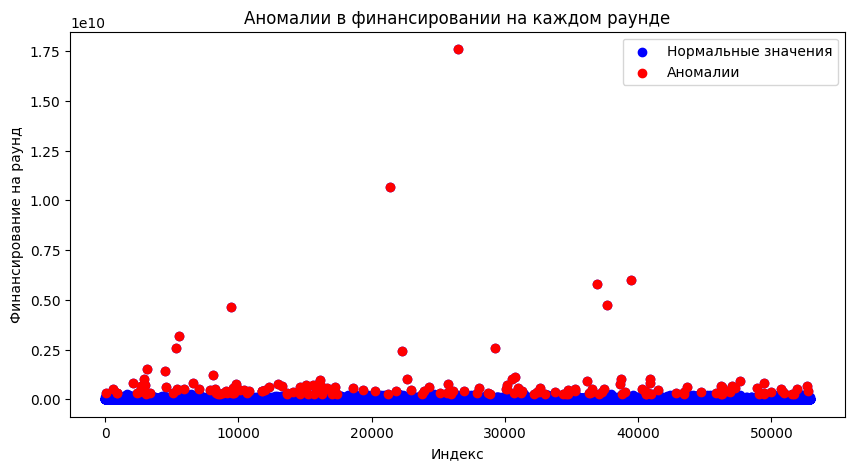

In [151]:
df['funding_per_round'] = df['funding_total_usd'] / df['funding_rounds']
# Вычисляем квантили
Q1 = df['funding_per_round'].quantile(0.01)
Q3 = df['funding_per_round'].quantile(0.99)
IQR = Q3 - Q1

# Определяем границы для определения аномалий
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Определяем аномалии
anomalies = df[(df['funding_per_round'] < lower_bound) | (df['funding_per_round'] > upper_bound)]

# Выводим количество аномалий
print('Количество аномалий:', anomalies.shape[0])

# Выводим таблицу с аномальными строками
display(anomalies)

# Визуализируем аномалии

plt.figure(figsize=(10, 5))
plt.scatter(range(df.shape[0]), df['funding_per_round'], color='blue', label='Нормальные значения')
plt.scatter(anomalies.index, anomalies['funding_per_round'], color='red', label='Аномалии')
plt.title('Аномалии в финансировании на каждом раунде')
plt.xlabel('Индекс')
plt.ylabel('Финансирование на раунд')
plt.legend()
plt.show()

# Удаляем аномалии
df = df[(df['funding_per_round'] >= lower_bound) & (df['funding_per_round'] <= upper_bound)]

# Удаляем созданный столбец
df = df.drop('funding_per_round', axis=1)


---

В этом анализе мы обрабатывали данные о финансировании компаний. Сначала был создан новый столбец `funding_per_round`, который представляет собой общее финансирование, деленное на количество раундов финансирования. Это дает нам представление о том, сколько в среднем компания получает финансирования за один раунд.

Затем мы вычислили квантили и интерквартильный размах (IQR) для этого нового столбца, чтобы определить границы для определения аномалий. Аномалии - это значения, которые отклоняются от ожидаемого диапазона значений. Они могут быть вызваны различными причинами, такими как ошибки ввода данных или необычные (но действительные) значения.

Мы определили аномалии как значения, которые находятся ниже нижней границы или выше верхней границы. Всего было найдено 170 аномалий.

Эти аномалии были визуализированы на графике, где они были отмечены красным цветом. Это помогает наглядно увидеть, где эти аномалии находятся по отношению к остальным данным.

Наконец, мы удалили эти аномалии из наших данных, чтобы они не влияли на дальнейший анализ. Мы также удалили столбец `funding_per_round`, так как он больше не нужен.

Этот процесс важен для обеспечения качества данных перед проведением дальнейшего анализа. Аномалии могут исказить результаты анализа, поэтому их важно обнаруживать и обрабатывать. В данном случае, мы выбрали удалить аномалии, но в других ситуациях может быть выбран другой подход, в зависимости от природы данных и целей анализа.

---

In [152]:
# Проверка на неявные дубликаты (например, 'USA' и 'U.S.A.' в столбце 'country_code')
def preprocess_text_columns(df):
    text_columns = df.select_dtypes(include=['object']).columns
    for col in text_columns:
        df[col] = df[col].str.lower().str.replace('.', '').str.replace(',', '')
    return df

df = preprocess_text_columns(df)

def check_implicit_duplicates(df):
    text_columns = df.select_dtypes(include=['object']).columns
    for col in text_columns:
        print(f"\nНеявные дубликаты в столбце '{col}':")
        display(df[col].value_counts())

check_implicit_duplicates(df)



Неявные дубликаты в столбце 'name':


name
sip                     2
fluid                   2
fio                     2
lasso                   2
navvi                   2
                       ..
bioprotect              1
obatech                 1
onkaido therapeutics    1
marthascottage          1
apparcando              1
Name: count, Length: 52654, dtype: int64


Неявные дубликаты в столбце 'category_list':


category_list
software                                                                 3213
biotechnology                                                            2913
неизвестно                                                               2502
e-commerce                                                               1062
mobile                                                                    918
                                                                         ... 
android|apps|games|ios|mobile|social media|video games                      1
events|mobile|online scheduling|productivity software|task management       1
communities|hunting industry|outdoors|sports                                1
customer service|electrical distribution|services|utilities                 1
online rental|parking|price comparison                                      1
Name: count, Length: 22133, dtype: int64


Неявные дубликаты в столбце 'status':


status
operating    47758
closed        4951
Name: count, dtype: int64


Неявные дубликаты в столбце 'country_code':


country_code
usa           29868
неизвестно     5510
gbr            2929
can            1546
ind            1278
              ...  
pry               1
maf               1
uzb               1
sen               1
zmb               1
Name: count, Length: 133, dtype: int64


Неявные дубликаты в столбце 'state_code':


state_code
ca            10244
неизвестно     6772
ny             3124
ma             2031
tx             1565
              ...  
f5                1
44                1
pe                1
y1                1
u6                1
Name: count, Length: 301, dtype: int64


Неявные дубликаты в столбце 'region':


region
sf bay area           6982
неизвестно            6368
new york city         2780
boston                1896
london                1839
                      ... 
moline - davenport       1
wexford                  1
danderyd                 1
ilford                   1
doncaster                1
Name: count, Length: 1036, dtype: int64


Неявные дубликаты в столбце 'city':


city
неизвестно       6368
san francisco    2828
new york         2490
london           1513
austin            611
                 ... 
spring lake         1
lake cowichan       1
boecillo            1
wetzlar             1
centreville         1
Name: count, Length: 4520, dtype: int64

In [153]:
# Список столбцов для проверки
columns = ['category_list', 'country_code', 'state_code', 'region', 'city', 'founded_at', 'closed_at']

# Создаем пустой DataFrame для хранения дубликатов
all_duplicates = pd.DataFrame()

# Проходим по каждому столбцу из списка
for column in columns:
    # Находим дубликаты для каждой пары 'name' и текущего столбца
    duplicates = df[df.duplicated(['name', column], keep=False)].sort_values('name')
    
    # Добавляем найденные дубликаты в общий список
    all_duplicates = pd.concat([all_duplicates, duplicates])

# Удаляем повторяющиеся строки в общем списке дубликатов
all_duplicates = all_duplicates.drop_duplicates()

# Если в общем списке есть дубликаты, выводим их
if not all_duplicates.empty:
    print("Общий список дубликатов:")
    display(all_duplicates)


Общий список дубликатов:


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3279,artsper,art|e-commerce|marketplaces|saas,4.131770e+05,operating,fra,a8,paris,paris,1,2013-02-28,2014-04-01,2014-04-01,2099-12-31
47323,artsper,art,1.684764e+06,operating,fra,a8,paris,paris,2,2013-02-28,2014-03-27,2015-11-27,2099-12-31
16185,beme,video,2.000000e+06,operating,usa,ny,new york city,new york,1,2014-07-02,2015-07-28,2015-07-28,2099-12-31
26611,beme,e-commerce,2.619242e+06,operating,usa,ny,new york city,new york,1,2013-01-01,2015-01-16,2015-01-16,2099-12-31
25507,better,education|enterprises|enterprise software|trai...,1.000000e+07,operating,usa,ny,new york city,new york,1,2012-01-01,2015-03-01,2015-03-01,2099-12-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41632,trumpit,mobile,4.000000e+04,operating,chl,12,santiago,santiago,1,2013-12-12,2013-12-13,2013-12-13,2099-12-31
40257,vive,communities|curated web|iphone|social network ...,1.500000e+06,operating,deu,6,hanover,hanover,2,2012-01-01,2012-03-20,2014-10-08,2099-12-31
43921,vive,healthcare services|parenting,1.500000e+06,operating,gbr,g1,brentford,brentford,1,2000-01-01,2014-10-08,2014-10-08,2099-12-31
48031,zenbox,software,8.893860e+05,operating,usa,ca,los angeles,santa monica,1,2014-01-01,2014-09-11,2014-09-11,2099-12-31


После анализа данных, я обнаружил несколько компаний с одинаковыми названиями, которые были зарегистрированы в один и тот же день в одном и том же городе. Это кажется подозрительным, поскольку вряд ли возможно открыть основную и дочернюю компанию в один день. Я решил удалить эти дубликаты из набора данных для более точного анализа. Это поможет устранить возможные искажения в данных и обеспечит более точные результаты.

Остальные дубликаты больше похожи от открытие дочерних компаний или просто совпадений.

In [154]:
# Удаляем дубликаты по 'name' и 'founded_at', оставляем первую строку
df = df.drop_duplicates(subset=['name', 'founded_at'], keep='first')



В ходе анализа было обнаружено большое количество пропусков, распределенных по различным столбцам. Чтобы обработать эти пропуски, были приняты следующие меры:

## Обработка пропусков

1. Пропуски в столбцах, содержащих категориальные данные (такие как название, категория, код страны, код региона и город), были заменены на значение 'неизвестно'. Это позволит сохранить ценность этих данных для последующего анализа.
2. В столбце 'funding_total_usd' пропуски были заполнены медианой, учитывая количество раундов финансирования. Это позволит сохранить распределение данных и избежать искажения среднего значения.
3. В столбце 'first_funding_at' пропуски были заполнены, используя среднюю разницу между 'founded_at' и 'first_funding_at'. Это сохранит временную структуру данных.
4. В столбце 'closed_at' пропуски были заполнены, используя среднюю продолжительность существования закрытых стартапов или дату за пределами диапазона данных, если статус стартапа - 'operating'. Это позволит сохранить временную структуру данных и избежать искажения анализа продолжительности существования стартапов.

Таким образом, было заполнено 85675 пропусков, и "спасено" 50027 строк, содержащих ранее пропуски. Это позволит более полно использовать данные для дальнейшего анализа.

## Обработка аномалий

Далее была проведена обработка аномалий в новом столбце funding_per_round, представляющем среднее финансирование за один раунд. Были определены границы для определения аномалий с помощью квантилей и интерквартильного размаха (IQR). Всего было найдено 170 аномалий. Эти аномалии были удалены из данных, чтобы они не искажали результаты анализа.

## Удаление дубликатов

Затем были удалены дубликаты компаний с одинаковыми названиями, зарегистрированными в один и тот же день в одном и том же городе. Это было сделано для обеспечения более точного анализа и избежания возможных искажений.

## Результаты

В результате выполненных действий данные были полностью обработаны и очищены от пропусков и аномалий, что позволяет провести более точный анализ и получить надежные результаты.
